In [27]:
import os
import pickle

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

from utils import set_matplotlib_configuration, get_accuracy_with_clustering

## CIFAR10 accuracy gains

Notebook for generating the table with accuracy gains. Change `DATA_PARTITION` to either `ho` or `val` to get the accuracy gain on the houldout clients or validation dataset of training clients, respectively.

In [28]:
PLOTTING_KWARGS, SAVEFIG_KWARGS = set_matplotlib_configuration(8.1)

In [29]:
DATA_PARTITION = "ho"
WEIGHTING = "weighted_average" # options -- average / weighted_average (weight by dataset size)
FOLDER = "cifar10_fedavg_accuracy_gains"
BASE_FOLDER = f"../outputs/{FOLDER}"

In [30]:
accuracies = []
for folder in glob(f"{BASE_FOLDER}/without_clustering_seed*/"):
    df = pd.read_csv(folder + f"{DATA_PARTITION}_accuracy.csv")
    with open(folder + "metric_evolution.pkl", "rb") as file:
        data = pickle.load(file)
    if WEIGHTING == "average":
        acc = df["accuracy"].mean()
    else:
        acc = (df["accuracy"] * df["dataset_size"]).sum() / df["dataset_size"].sum()
    accuracies.append(acc)
    _, a = zip(*data["test_accuracy"])
WO_CLUSTERING_MEAN, std = np.mean(accuracies)*100, np.std(accuracies)*100 / np.sqrt(3)
f"Average accuracy without clustering: {WO_CLUSTERING_MEAN:.2f} +/- {std:.2f}"

/Users/radovib/.venv/torch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/radovib/.venv/torch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/radovib/.venv/torch/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/radovib/.venv/torch/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/radovib/.venv/torch/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


'Average accuracy without clustering: nan +/- nan'

In [20]:
COLEDS_CONFIGURATION = "0.25 8"
df = get_accuracy_with_clustering(BASE_FOLDER, DATA_PARTITION, WEIGHTING)
df = df[df["num_clusters"] != 64]
df = df[(df["method"] != "CoLEDS") | ((df["method"] == "CoLEDS") & (df["meta"] == COLEDS_CONFIGURATION))]
print((df.groupby(["method", "num_clusters", "meta"]).size()).mean())
df = df.groupby(["method", "num_clusters", "meta"])["acc"].agg(["mean", "std"]).reset_index()
df = df.pivot(index="num_clusters", columns="method", values=["mean", "std"]) * 100
df = df.reindex(columns=pd.MultiIndex.from_product([["mean", "std"], ["WDP", "LbP", "CoLEDS", "AESP", "REPA"]]))
df["mean"]

4.92


,WDP,LbP,CoLEDS,AESP,REPA
num_clusters,,,,,
2,56.785359,59.438743,53.767278,53.035589,54.213036
4,58.157319,61.503160,56.622143,53.214030,55.023740
8,64.748582,65.268342,61.848029,52.107909,53.921762
16,68.411997,67.969871,62.238332,53.292559,55.415132
32,67.877780,68.863592,63.916293,53.172201,57.577940


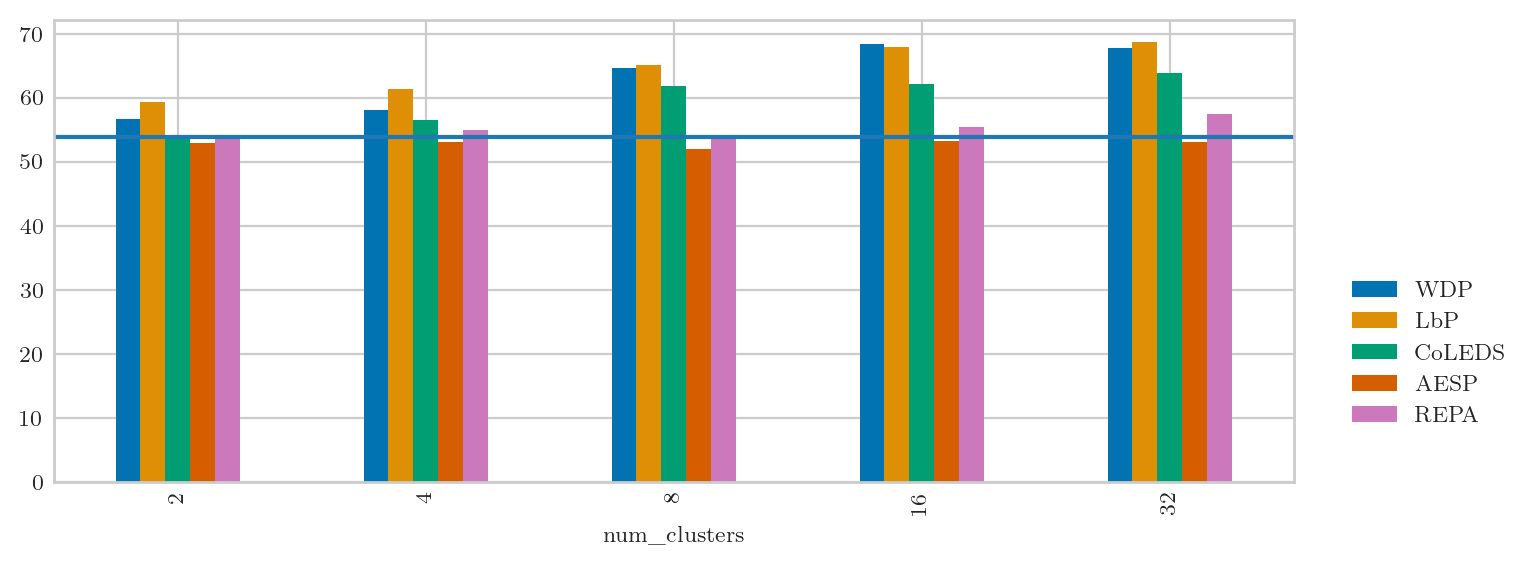

In [21]:
df["mean"].plot(kind="bar", figsize=(8, 3), **PLOTTING_KWARGS)
plt.gca().axhline(WO_CLUSTERING_MEAN)
# plt.ylim(75, 85)
plt.legend(loc=(1.04, 0.1))

In [22]:
# df = get_accuracy_with_clustering(BASE_FOLDER, DATA_PARTITION, WEIGHTING)
# assert (df.groupby(["method", "num_clusters", "meta"]).size() == 3).all()
# assert (df[df["method"] == "CoLEDS"].groupby("num_clusters").size() == 3).all()
# df = df.groupby(["method", "num_clusters", "meta"])["acc"].agg(["mean", "std"]).reset_index()
# df = df.pivot(index="num_clusters", columns="method", values=["mean", "std"]) * 100
# df = df.reindex(columns=pd.MultiIndex.from_product([["mean", "std"], ["WDP", "LbP", "CoLEDS", "AESP", "REPA"]]))
# df["mean"].plot(kind="bar")
# plt.gca().axhline(WO_CLUSTERING_MEAN)

In [23]:


# tmp = df[~((df["method"] == "CoLEDS") & (df["meta"] != "0.25 32"))].drop("meta", axis=1)
# tmp = tmp.reindex(columns=pd.MultiIndex.from_product([["mean", "std"], ["WDP", "LbP", "CoLEDS", "AESP", "REPA"]]))
# tmp["mean"].plot(kind="bar", figsize=(6, 2), legend=None, rot=0)
# plt.legend(loc=(1.01, 0.0))
# # plt.ylim(75, 85)

In [24]:
# df = get_accuracy_with_clustering(BASE_FOLDER, DATA_PARTITION, WEIGHTING)
# # assert (df.groupby(["method", "num_clusters", "meta"]).size() == 3).all()

# df = df.groupby(["method", "num_clusters", "meta"])["acc"].agg(["mean", "std"]).reset_index()
# coleds_df = df.loc[df[df["method"] == "CoLEDS"].groupby("num_clusters")["mean"].idxmax()].drop("meta", axis=1)
# df = pd.concat([df[df["method"] != "CoLEDS"], coleds_df]).drop("meta", axis=1)
# df = df.pivot(index="num_clusters", columns="method", values=["mean", "std"]) * 100
# df["mean"] -= WO_CLUSTERING_MEAN
# df["std"] /= np.sqrt(3)
# df = df.reindex(columns=pd.MultiIndex.from_product([["mean", "std"], ["WDP", "LbP", "CoLEDS", "AESP", "REPA"]]))

In [25]:
# # plotting
# df["mean"].plot(kind="bar", rot=0, **PLOTTING_KWARGS, figsize=(5, 3))
# plt.legend(loc=(1.05, 0.1), )

In [26]:
# Format `df` for LaTeX with per-row highlighting:
# best -> \textbf, second -> \underline, third -> \emph.
# Only the mean value is styled, not the "± std".
def _format_cell(mean_val, std_val, style=None):
    mean_str = f"{mean_val:.2f}"
    if style == "best":
        mean_str = r"\bm1{" + mean_str + "}"
    elif style == "second":
        mean_str = r"\bm2{" + mean_str + "}"
    elif style == "third":
        mean_str = r"\bm3{" + mean_str + "}"

    if pd.isna(std_val):
        return mean_str
    return mean_str + r" \tiny{$\pm " + f"{std_val:.2f}" + r"$}"

df["mean"] -= WO_CLUSTERING_MEAN
order = ["LbP", "WDP", "CoLEDS", "AESP", "REPA"]
formatted_df = pd.DataFrame(index=df.index, columns=order, dtype=object)

for idx in df.index:
    # collect means for this row
    row_means = {
        m: df.loc[idx, ("mean", m)]
        for m in order
        if ("mean", m) in df.columns
    }

    # rank methods by mean (descending)
    ranked = sorted(row_means.items(), key=lambda x: x[1], reverse=True)
    styles = {}
    if len(ranked) > 0:
        styles[ranked[0][0]] = "best"
    if len(ranked) > 1:
        styles[ranked[1][0]] = "second"
    if len(ranked) > 2:
        styles[ranked[2][0]] = "third"

    # fill formatted table row
    for m in order:
        if ("mean", m) in df.columns and ("std", m) in df.columns:
            mean_val = df.loc[idx, ("mean", m)]
            std_val = df.loc[idx, ("std", m)]
            style = styles.get(m)
            formatted_df.loc[idx, m] = _format_cell(mean_val, std_val, style)
        else:
            formatted_df.loc[idx, m] = ""

formatted_df.index.name = "Number of clusters"
latex_table = formatted_df.reset_index().to_latex(
    escape=False,
    index=False,
    column_format="r||ccccc",
)
print(latex_table)

\begin{tabular}{r||ccccc}
\toprule
Number of clusters & LbP & WDP & CoLEDS & AESP & REPA \\
\midrule
2 & \bm1{5.44} \tiny{$\pm 1.36$} & \bm2{2.79} \tiny{$\pm 2.97$} & -0.23 \tiny{$\pm 0.46$} & -0.96 \tiny{$\pm 2.92$} & \bm3{0.21} \tiny{$\pm 2.55$} \\
4 & \bm1{7.50} \tiny{$\pm 1.49$} & \bm2{4.16} \tiny{$\pm 3.65$} & \bm3{2.62} \tiny{$\pm 1.75$} & -0.79 \tiny{$\pm 2.77$} & 1.02 \tiny{$\pm 3.56$} \\
8 & \bm1{11.27} \tiny{$\pm 2.70$} & \bm2{10.75} \tiny{$\pm 2.09$} & \bm3{7.85} \tiny{$\pm 1.44$} & -1.89 \tiny{$\pm 2.61$} & -0.08 \tiny{$\pm 3.15$} \\
16 & \bm2{13.97} \tiny{$\pm 1.76$} & \bm1{14.41} \tiny{$\pm 1.31$} & \bm3{8.24} \tiny{$\pm 2.68$} & -0.71 \tiny{$\pm 3.23$} & 1.42 \tiny{$\pm 4.47$} \\
32 & \bm1{14.86} \tiny{$\pm 1.91$} & \bm2{13.88} \tiny{$\pm 0.61$} & \bm3{9.92} \tiny{$\pm 3.19$} & -0.83 \tiny{$\pm 3.97$} & 3.58 \tiny{$\pm 2.06$} \\
\bottomrule
\end{tabular}



Note: the above latex tabular highlights the first, second and third value. To make it work with the provided style, include the following to your latex document:

```latex
\usepackage{tikz}
\definecolor{gold}{HTML}{FBF2D2}
\definecolor{silver}{HTML}{DDDDDD}
\definecolor{bronze}{HTML}{EED2B8}
\definecolor{goldD}{HTML}{D9AE13}
\definecolor{silverD}{HTML}{909090}
\definecolor{bronzeD}{HTML}{9A5F26}
\newcommand{\medal}[3]{\tikz[baseline=(char.base)]{\node[rounded corners=2pt,fill=#1,draw=#2,inner sep=1.5pt] (char) {#3};}}

\newcommand{\bm}[2]{
    \ifcase#1\or% case 1
      {\medal{gold}{goldD}{\textbf{#2}}}
    \or % case 2
      {\medal{silver}{silverD}{#2}}
    \or % case 3
      {\medal{bronze}{bronzeD}{#2}}
    \else % default case
      #2
    \fi\ignorespaces
}
```